## Final Assignment in MLiM (WS 2020/21)

#### Anna Franziska Bothe - 576309


### Set up

In [7]:
#reassign your corresponding paths
#path where the data sets are stored
path_datasets = '/Users/Bisa/Documents/Studium/Masterstudium/5_Semester/MLiM/datasets'
#path where the checkpoint files will be stored (e.g. the final word2vec model)
path_checkpoints = '/Users/Bisa/Documents/Studium/Masterstudium/5_Semester/MLiM/FinalAssignment'

In [8]:
#load packages
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

#for association rule mining
import mlxtend 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [9]:
#load data
#customers past purchase (week 0-89, shopper, product, price in € cents)
basket = pq.read_table(path_datasets + '/baskets.parquet').to_pandas()
#coupons customers received in the past (week, shopper, product, discount in %)
coupon = pq.read_table(path_datasets + '/coupons.parquet').to_pandas()

#data for final prediction (shopper, week, coupon, product, discount)
pred_coup = pq.read_table(path_datasets + '/coupon_index.parquet').to_pandas()

In [10]:
basket.info(), coupon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68841598 entries, 0 to 68841597
Data columns (total 4 columns):
 #   Column   Dtype
---  ------   -----
 0   week     int64
 1   shopper  int64
 2   product  int64
 3   price    int64
dtypes: int64(4)
memory usage: 2.6 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000000 entries, 0 to 44999999
Data columns (total 4 columns):
 #   Column    Dtype
---  ------    -----
 0   week      int64
 1   shopper   int64
 2   product   int64
 3   discount  int64
dtypes: int64(4)
memory usage: 1.7 GB


(None, None)

In [11]:
#merge data sets
basket_coupon_df = pd.merge(basket, coupon, on = ['week', 'shopper', 'product'], how = 'left')
basket_coupon_df.info()

In [4]:
#tsne plotting function

def tsne_plot(model, perplexity, no_iterations):
    'Creates and TSNE model and plots it'
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='random', n_iter=no_iterations, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom'
                    )
    
    plt.show()

### Data Exploration

In [5]:
print(basket.shape)
print(coupon.shape)
print(pred_coup.shape)

(68841598, 4)
(45000000, 4)
(10000, 3)


In [6]:
print('Unique shoppers: ', basket['shopper'].nunique())
print('Unique products: ', basket['product'].nunique())

Unique shoppers:  100000
Unique products:  250


In [7]:
print('Max. transactions/bought products per day: ', basket['week'].value_counts().max())

Max. transactions/bought products per day:  766612


In [8]:
#0 means no discount, 1-4 are the discounts 15%, 20%, 25%, 30%
pred_coup['coupon'].value_counts()

4    2000
3    2000
2    2000
1    2000
0    2000
Name: coupon, dtype: int64

In [9]:
#discount are distributed equally
coupon['discount'].value_counts()

25    6431616
40    6431548
10    6429740
35    6429196
30    6427814
20    6425420
15    6424666
Name: discount, dtype: int64

In [10]:
#null values
#as expected: no null values in both data frames
coupon.isnull().sum().sum(), basket.isnull().sum().sum()

(0, 0)

In [5]:
#counts with product is bought how often by which shopper 
shopper_prod = pd.crosstab(basket['shopper'], basket['product'])
shopper_prod.head(10)

product,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
shopper,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,8,0,0,0,0,0,...,1,0,0,1,7,0,0,0,0,13
1,6,13,0,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,0,46,0,0,0,0,5,0,0,2,...,12,0,0,0,0,1,0,0,9,5
3,0,0,0,0,3,0,28,6,0,0,...,0,0,0,1,0,2,0,0,12,3
4,0,0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,46,0,0,0,0,0,0,0
6,0,12,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,20,0
7,0,0,0,25,0,0,3,0,0,0,...,0,0,2,0,0,0,8,0,2,33
8,0,0,0,2,6,0,0,0,0,0,...,0,2,0,0,0,0,0,1,0,24


In [ ]:
'''TO DO: make crosstab to find out which products were often bought with coupon'''

### Analysis

In [11]:
#only 250 different products
#shorten data frame --> only take the 100 most frequent products
product_count = basket['product'].value_counts().reset_index()
product_count.columns = ['product', 'occurence']
list_most_freq_products = product_count.loc[0:100, 'product']
df_most_freq_products = basket[basket['product'].isin(list_most_freq_products)]
#change of names
baskets = df_most_freq_products.copy()

'TO DO: write a test function for the following part'
#check if everything worked; result of unique product in new data set should be 101 now
print(baskets['product'].nunique())
#show head of new data set
baskets.head()

101


,week,shopper,product,price
0,0,0,71,629
2,0,0,116,715
3,0,0,123,483
5,0,0,167,582
6,0,0,171,639


In [12]:
#a string input is needed for the word2vec model because it originates in NLP
baskets['product'] = baskets['product'].astype(str)
baskets['week'] = baskets['week'].astype(str)
baskets['shopper'] = baskets['shopper'].astype(str)
#create a basket id to identify each basket --> connecting week and shopper will give an unique each
baskets['basket_id'] = baskets['week'] + '-' + baskets['shopper']

baskets.head()

,week,shopper,product,price,basket_id
0,0,0,71,629,0-0
2,0,0,116,715,0-0
3,0,0,123,483,0-0
5,0,0,167,582,0-0
6,0,0,171,639,0-0


-------------------------------------------

## Checkpoint 1

a) **save** baskets data set

In [13]:
baskets.to_parquet(path_checkpoints + '/baskets.parquet')

'TO DO: write function for checkpoints'

'TO DO: write function for checkpoints'

b) **load** baskets data set

In [ ]:
baskets = pq.read_table(path_checkpoints + '/baskets.parquet').to_pandas()

-------------------------------------------------

### TSNE

In [14]:
input = baskets.groupby('basket_id').agg({'product':lambda x: list(x)}).reset_index()
input = input['product'].tolist()
input[0]

['71', '116', '123', '167', '171', '184', '225']

In [15]:
#Word2Vec model
model = Word2Vec(input, min_count = 30, size = 30, workers = 4, window = 6, sg = 1) 
model.wv.similarity('71', '116')

0.04390894

-------------------------------------------

## Checkpoint 2

a) **save** word to vec model

In [16]:
model.save(path_checkpoints + '/products_top100.model')

b) **load** word2vec model

In [17]:
model = Word2Vec.load(path_checkpoints + '/products_top100.model')

-------------------------------------------------

In [18]:
#insert product (it is the 'product_id')
x = '71'

#most similar products to product x
print(model.wv.most_similar(x)) #model with max of 100 products

#top 5 products most similar to product x
most_bought = baskets[(baskets['product'] == model.wv.most_similar(x)[0][0]) | (baskets['product'] == model.wv.most_similar(x)[1][0]) | (baskets['product'] == model.wv.most_similar(x)[2][0]) | 
                      (baskets['product'] == model.wv.most_similar(x)[3][0]) | (baskets['product'] == model.wv.most_similar(x)[4][0])]
print('The products most similar to {} are: {}'.format(x, most_bought['product'].unique()))

[('76', 0.7030895352363586), ('78', 0.6651766300201416), ('74', 0.6360448002815247), ('75', 0.5882651805877686), ('184', 0.3895338475704193), ('171', 0.31924787163734436), ('47', 0.2461760938167572), ('214', 0.22789457440376282), ('66', 0.2235073745250702), ('191', 0.2210409939289093)]
The products most similar to 71 are: ['184' '76' '74' '78' '75']


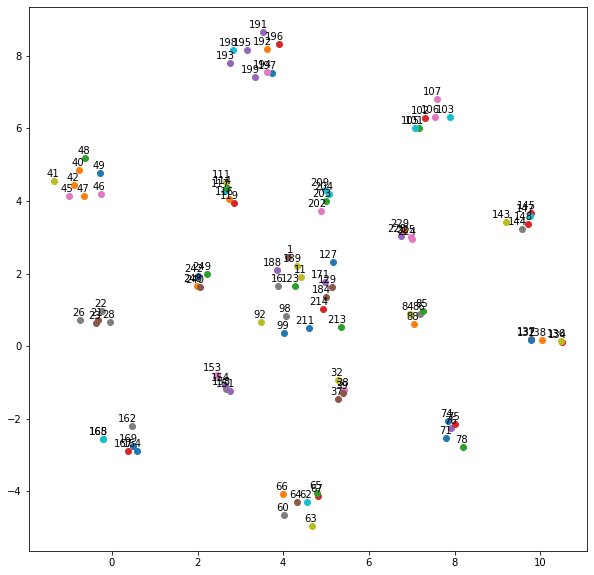

In [19]:
#plot in 2-dim tsne graph 
tsne_plot(model, 30, 5000)

'''the results look to structured; I changed only init in the TSNE function from 'pca' to 'init'; what is happening in the
center of the plot? Different numbers are combined to one fuzzy cluster there'''

### Frequent Item Sets aka Association Analysis

Use apriori algorithm with the MLxtend package. Suitable for larger data sets. Tested with only 50.000 observations so far. Running ~68.000.000 should be feasible but takes time

Source: https://pbpython.com/market-basket-analysis.html

In [20]:
#splitting off the first 50.000 observations
itemsets_freq = baskets.copy()
itemsets_freq.reset_index(drop = True)
itemsets_freq = itemsets_freq.iloc[1:50000]
itemsets_freq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 2 to 110064
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   week       69999 non-null  object
 1   shopper    69999 non-null  object
 2   product    69999 non-null  object
 3   price      69999 non-null  int64 
 4   basket_id  69999 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.2+ MB


In [21]:
itemsets_freq = (itemsets_freq.groupby(['basket_id', 'product']).sum().unstack().reset_index().fillna(0).set_index('basket_id'))
itemsets_freq.head()

price                                                   ...       \
product       1    101  102    103  105  106  107   11  111  114  ...   75   
basket_id                                                         ...        
0-0         0.0    0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
0-1         0.0    0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
0-10        0.0  506.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
0-100       0.0    0.0  0.0  539.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
0-1000      0.0  506.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

                                                            
product     76   78     84   85   86   88     92   98   99  
basket_id                                                   
0-0        0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0  
0-1        0.0  0.0    0.0  0.0  0.0  0.0  543.0  0.0  0.0  
0-10       0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0  
0-100      0.0  0.0  501.0  0.0  0.0  0.0    0.0  0.0  0.0  
0-1000     0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0  0.0  

[5 rows x 101 columns]

In [22]:
#create dummy variables
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = itemsets_freq.applymap(encode_units)

-------------------------------------------

## Checkpoint 3

a) **save** basket sets

In [23]:
basket_sets.to_csv(path_checkpoints + '/basket_sets.csv')

b) **load** basket sets

In [ ]:
basket_sets = pd.read_csv(path_checkpoints + '/basket_sets.csv')

-------------------------------------------------

In [1]:
frequent_itemsets = apriori(basket_sets, min_support=0.001, use_colnames=True)
#min. support level of 0.01%

NameError: name 'apriori' is not defined

In [ ]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules.head()

In [ ]:
#weirdly 0 which I find odd
rules[rules['lift'] < 1]

#### Interpretation of the results

**Support**

Rel. frequency that the applied rules show up. Higher support might indicate a more useful relationship; however, low support can also signalize 'hidden' relationships.

**Confidence** 

Measure of reliability of the rule. For instance, a confidence of 0.5 would mean that 50% of the cases where product a was bought, product b was also purchased. According to our data set, product 101 was bought in combination with product 1 in 11% of the baskets.

**Lift**

Ratio of observed support if two rules were independent. Rule of thumb: if the lift is close to 1, the rules are completly independent. If the lift is greater than 1, the product combination is in general more 'interesting' because it indicates an useful pattern.

If the lift is > 1, that lets us know the degree to which those two occurrences are dependent on one another, and makes those rules potentially useful for predicting the consequent in future data sets.

If the lift is < 1, that lets us know the items are substitute to each other. This means that presence of one item has negative effect on presence of other item and vice versa.

Source: https://en.wikipedia.org/wiki/Association_rule_learning#Support

### Clustering

Form group like e.g. departments, product categories

#### ***@all***: 
Somehow it is not possible to cluster with tsne directly?? Did I get something wrong? 

Moreover, hierarchical clustering does not work on our amount of data. I tried on a 100.000x250 data frame (see code below) and it crushes my computational resources completely


In [ ]:
#wont work with big data sets like ours

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(cust_prod, 'single')

#labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

### Timely Pattern per Shopper/Item

### Cooccurences of Items

### Heuristic model

Idea: weight highest price with the frequency of purchases. Take the deviation of the original (max. price of product in data set) in order to set the coupon value. As a first guess, the assigned weight is 50%/50%. In order to prevent from skewness due to higher values in price, both variable will be normalized before being weighted.

$max return = max(0.5(norm(price))+0.5(norm(purchases)))$